# Medical Notes Classification

Medical notes is an useful information source for patient data extraction. Notes classification is also an important task in Medical NLP domain. There are many techniques to solve this problem ranging from traditional method (Logistic Regression, SVM,...) to the state-of-the-art models (Transformer).

The below code block is the baseline model for a text classification problem in medical domain.

* Input: the corpus of medical transcriptions.
* Output: the type of each notes.

In this problem, we try to classify five labels:
* Surgery
* Consult - History and Phy.
* Cardiovascular / Pulmonary
* Orthopedic
* Others

The train-test split was also defined, please don't change our split.

Metric to evaluate: `f1_macro`

# Baseline Model Result


0.3729330560342061

                                precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.35      0.39      0.37       148
    Consult - History and Phy.       0.32      0.06      0.10       207
                    Orthopedic       0.39      0.14      0.21       142
                         Other       0.66      0.74      0.70      1055
                       Surgery       0.43      0.57      0.49       435

                      accuracy                           0.56      1987
                     macro avg       0.43      0.38      0.37      1987
                  weighted avg       0.54      0.56      0.53      1987

# Library & Data Loading

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


### PLEASE DON'T CHANGE ANYTHING IN THIS SECTION ###
DATA = "https://github.com/socd06/private_nlp/raw/master/data/mtsamples.csv"

filtered_labels = [
    "Surgery",
    "Consult - History and Phy.",
    "Cardiovascular / Pulmonary",
    "Orthopedic",
]
data = pd.read_csv(DATA, usecols=['medical_specialty', 'transcription']).dropna()
data.columns = ['labels', 'text']
data['labels'] = [i.strip() if (i.strip() in filtered_labels) else 'Other' for i in data.labels.to_list()]
train, test = train_test_split(data, test_size=0.4, stratify=data.labels, random_state=0)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
### END ###

# Preprocessing

# My Model


In [2]:
#encode labels 
le = LabelEncoder()
train['labels'] = le.fit_transform(train.labels)
test['labels'] = le.transform(test.labels)

### Encode Text


In [ ]:
vector_size = 500
segment_size = 20
data_enrichment = 3

In [3]:
#create model
import TopicAllocate as ta
model = ta.Topic_Allocate()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\haimi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\haimi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
#encode texts into matrix
X_train = np.asarray(model.doc2vec(train['text'], vector_size = vector_size, segment_size = segment_size, data_enrichment = data_enrichment, fit = True))
X_test = np.asarray(model.doc2vec(test['text'], vector_size = vector_size, segment_size = segment_size, data_enrichment = data_enrichment))


C:\Users\haimi\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [5]:
# onehot labels
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

y_train = train['labels']

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
Y_train = onehot_encoder.fit_transform(np.array(y_train).reshape(-1, 1))
Y_test = onehot_encoder.transform(np.array(test['labels']).reshape(-1,1))

# invert first example
inverted = le.inverse_transform([np.argmax(Y_train[0, :])])
print(inverted)

['Consult - History and Phy.']


### Train with LSTM

#### sequence -> vec

In [6]:
#%% import library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [7]:
max_size = np.amax(np.array([x.shape[0] for x in X_train]))
def fill_zeros(x, Vector_size):
    try:
        missing = max_size - x.shape[0]
        fill_in = np.zeros((missing, Vector_size))
        return np.vstack((fill_in, x))
    except:
        return np.zeros((max_size, Vector_size))
func = lambda x: fill_zeros(x, 500)
X_train_lstm_s2v = np.array([func(x) for x in X_train])
X_test_lstm_s2v = np.array([func(x) for x in X_test])


In [8]:
#%% Xay dung model LSTM
lstm_model = Sequential()
# return_sequences: tra lai ket qua cuoi cho lop tiep theo
lstm_model.add(LSTM(units=500, return_sequences=True, input_shape=(X_train_lstm_s2v.shape[1], X_train_lstm_s2v.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=5, activation="softmax"))
lstm_model.compile(optimizer="adam", loss="categorical_crossentropy",  metrics=["accuracy"])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 74, 500)           2002000   
_________________________________________________________________
dropout (Dropout)            (None, 74, 500)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                110200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 255       
Total params: 2,112,455
Trainable params: 2,112,455
Non-trainable params: 0
_________________________________________________________________


In [9]:
lstm_model.fit(X_train_lstm_s2v, Y_train, epochs=10, batch_size=32, validation_split= 0.1)

Epoch 1/10
84/84 [==============================] - 15s 100ms/step - loss: 1.1699 - accuracy: 0.5479 - val_loss: 1.0693 - val_accuracy: 0.5705
Epoch 2/10
84/84 [==============================] - 8s 93ms/step - loss: 1.0330 - accuracy: 0.5554 - val_loss: 1.0248 - val_accuracy: 0.5336
Epoch 3/10
84/84 [==============================] - 8s 98ms/step - loss: 0.9859 - accuracy: 0.5554 - val_loss: 0.9260 - val_accuracy: 0.5604
Epoch 4/10
84/84 [==============================] - 8s 95ms/step - loss: 0.9470 - accuracy: 0.5666 - val_loss: 0.9061 - val_accuracy: 0.5839
Epoch 5/10
84/84 [==============================] - 8s 96ms/step - loss: 0.9169 - accuracy: 0.5670 - val_loss: 0.9294 - val_accuracy: 0.5470
Epoch 6/10
84/84 [==============================] - 8s 98ms/step - loss: 0.8994 - accuracy: 0.5658 - val_loss: 0.8962 - val_accuracy: 0.6007
Epoch 7/10
84/84 [==============================] - 8s 98ms/step - loss: 0.8867 - accuracy: 0.5714 - val_loss: 0.8917 - val_accuracy: 0.5537
Epoch 8/10


In [10]:
from sklearn.metrics import confusion_matrix
check = lstm_model.predict(X_test_lstm_s2v)
check = np.argmax(check, axis = 1)
ytrain = np.argmax(Y_test, axis = 1)
print(confusion_matrix(check, ytrain))
print(metrics.f1_score(ytrain, check, average='macro'))
print(metrics.classification_report(ytrain, check, target_names=list(le.classes_)))

[[ 36  22   3  35   3]
 [  0   0   0   4   0]
 [  0   1  13   7  12]
 [ 39 184  60 895 217]
 [ 73   0  66 114 203]]
0.3252698876358024
                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.36      0.24      0.29       148
Consult - History and Phy.       0.00      0.00      0.00       207
                Orthopedic       0.39      0.09      0.15       142
                     Other       0.64      0.85      0.73      1055
                   Surgery       0.45      0.47      0.46       435

                  accuracy                           0.58      1987
                 macro avg       0.37      0.33      0.33      1987
              weighted avg       0.49      0.58      0.52      1987



(array([ 50.,  28.,  42.,  75., 115., 157., 124., 170., 157., 148., 131.,
        157., 124., 141., 119., 105., 104.,  89.,  72.,  81.,  84., 100.,
         42.,  63.,  49.,  67.,  42.,  40.,  29.,  28.,  34.,  24.,  22.,
         14.,  29.,   6.,  14.,  11.,   7.,   5.,   7.,   8.,   1.,   3.,
          7.,   6.,   6.,   4.,   0.,   1.,   4.,   3.,   4.,   2.,   1.,
          3.,   2.,   0.,   2.,   1.,   0.,   5.,   0.,   0.,   2.,   0.,
          4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.]),
 array([1.00000e+00, 3.12800e+01, 6.15600e+01, 9.18400e+01, 1.22120e+02,
        1.52400e+02, 1.82680e+02, 2.12960e+02, 2.43240e+02, 2.73520e+02,
        3.03800e+02, 3.34080e+02, 3.64360e+02, 3.94640e+02, 4.24920e+02,
        4.55200e+02, 4.85480e+02, 5.15760e+02, 5.46040e+02, 5.76320e+02,
        6.06600e+02, 6.368

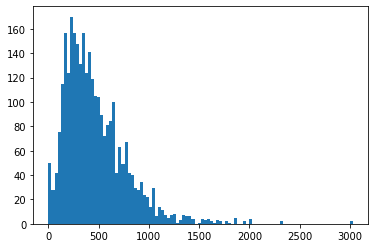

In [11]:
# texts = train['text']
# texts = [text.split() for text in texts]
# train_lent  = np.array([len(text) for text in texts])
# import matplotlib.pyplot as plt
# plt.hist(lent, bins = 100)